Matched halo number: 78551
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
mass range: 6809999882846.207 866449946956529.6
mass range (log/ln): 29.54941321888677 34.39542545879549


/users/lyang4/borah_scratch/multi_wave/N3600/shuffle/Github_code/expected_profiles_wu2022.py:139: RuntimeWarning: invalid value encountered in divide
  w2_over_N = np.where(N_i > 0, (pdf_sel**2) / N_i, 0.0)


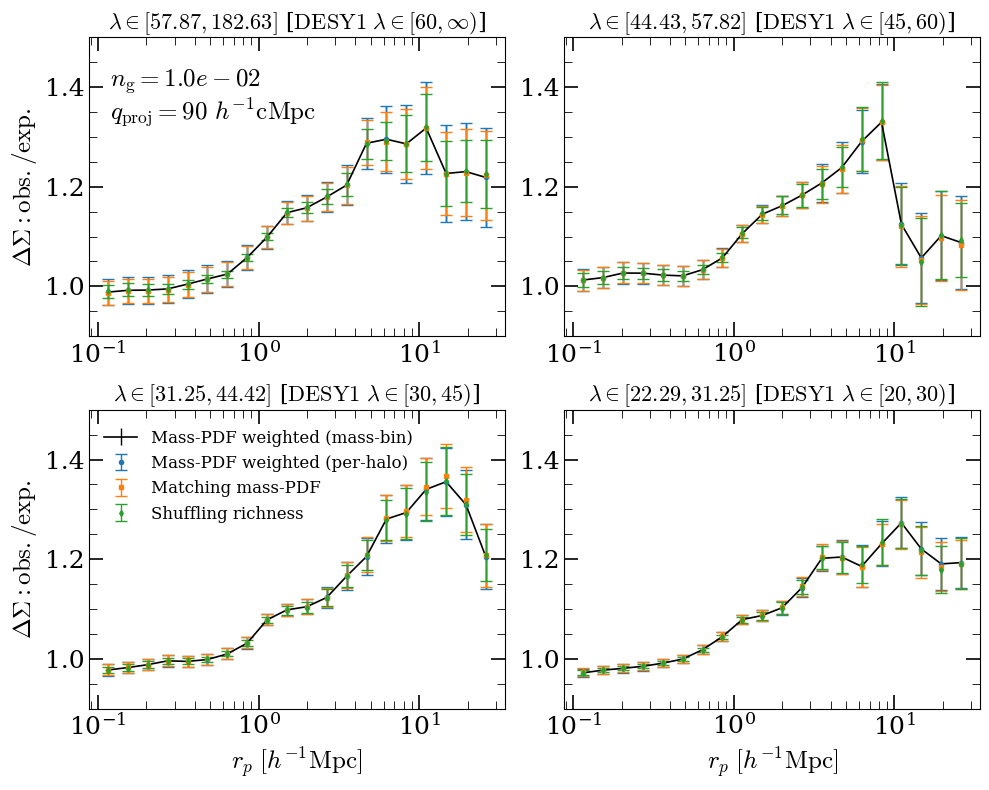

In [1]:
# run main.py in Jupyter_Notebook
import os
import numpy as np
import matplotlib.pyplot as plt

from read_data_flamingo import (
    setup_flamingo_cosmology,
    load_halo_id,
    load_cylinder_cluster_richness,
    load_cylinder_cluster_halo_matchID,
    load_halo_lensing_data,
    load_halo_cy_data,
    verify_ids_match,
    calc_mean_lensing_with_std_err,
    calc_mean_cy_with_std_err,
    colossus_nfw_DS_Sigma_at_rp,
)

from expected_profiles_wu2022 import (
    mass_pdf_weighted_lensing_with_sampling_err, # Wu22 appendix B method(iii) old version (mass-bin weighting)
    mass_pdf_weighted_per_halo_lensing,          # Wu22 appendix B method(iii) per-halo weighting version
    mass_matched_sample_expected,                # Wu22 appendix B method(ii) 
    shuffled_richness_selection_bias_ratio       # Wu22 appendix B method(i)
)


plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"

# --- Paths ---
cat_base = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/HYDRO_FIDUCIAL/z0.3/"
data_m3_path = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/data/data_m3/"
halo_prop_path = (
    "/projects/lyang4/projection_effects/cluster_cosmology/multi_wave/halos/"
    "L1000N3600_HYDRO_FIDUCIAL_halos_m500c_cut_1e13_withID.hdf5"
)
def main():
    # --- Cosmology (Colossus) ---
    _ = setup_flamingo_cosmology()

    # Load halo_id once
    halo_id = load_halo_id(halo_prop_path)

    # --- User parameters ---
    Mcut = 1e13 ### Unit: Msun (6.81e12 Msun/h)
    gal_dens = ["1.2e-02", "1.0e-02", "8.0e-03", "6.0e-03", "4.0e-03", "2.0e-03", "1.0e-03"]
    gal_dens_num = [1.2e-2, 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3]

    cyl_depth = [30, 60, 90, 120, 180] ### comoving Mpc/h for count-in-cylinder richness
    proj_depth = [60, 90, 180, 300]    ### comoving Mpc/h for r_{\pi} lensing and cy

    Mz_cut = [20, 21, 21.5, 22]  ### z-band abs_magnitdue cut  (negligible)
    chi2_cut = [6, 8, 10, 50, 100, 150] ### chi2_cut for color (does not matter)

    richness_labels = [
        r" [$\rm DESY1~\lambda\in[60, \infty)$]",
        r" [$\rm DESY1~\lambda\in[45, 60)$]",
        r" [$\rm DESY1~\lambda\in[30, 45)$]",
        r" [$\rm DESY1~\lambda\in[20, 30)$]",
    ]

    numlam_DESY1 = np.array([0, 280, 379, 1159, 2349])  # cumulative edges

    n_rpbins = 20


    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # For diagnostic: fix three indices 
    cc = 0   # chi2_cut index -> 6
    mz = 0   # Mz_cut index  -> 20 absmag
    k  = 3   # proj_depth index -> 300 cMpc/h

    for i in range(1, 2):   # gal_dens index -> 1e02
        for j in range(2, 3):  # cyl_depth index -> 90 cMpc/h
            model_dir = os.path.join(cat_base, f"model_redmagic_chi{chi2_cut[cc]}_{gal_dens[i]}_HBT")

            file_matchID  = os.path.join(
                model_dir,
                f"matched_haloID_M500c_cut{Mcut:.0e}_q{cyl_depth[j]}_Mz_cut-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )
            file_richness = os.path.join(
                model_dir,
                f"richness_q{cyl_depth[j]}_bg_NOmiscen_m500c_Mzmin-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )

            if not os.path.exists(file_richness):
                print("[**skip**] richness file missing:", file_richness)
                continue

            richness, cyl_hm, cyl_hid = load_cylinder_cluster_richness(file_richness)
            matched_id = load_cylinder_cluster_halo_matchID(file_matchID)

            halo_mass, DS_halo, Sigma_halo, rp_list, hid_lensing = load_halo_lensing_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )
            hmass_cy, cy_halo, rp_cy, hid_cy = load_halo_cy_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )

            # Sanity check ID alignment
            if not verify_ids_match({"lensing": hid_lensing, "richness": cyl_hid}):
                print("[warn] lensing IDs do not match richness IDs")
            if not verify_ids_match({"cy": hid_cy, "richness": cyl_hid}):
                print("[warn] cy IDs do not match richness IDs")

            print("Matched halo number:", len(richness))

            # Rank by cic-richness
            sort_lam = np.argsort(richness)[::-1]
            richness_sort = richness[sort_lam]
            hm_sort       = halo_mass[sort_lam]
            DS_sort       = DS_halo[sort_lam]
            Sigma_sort    = Sigma_halo[sort_lam]
            cy_sort       = cy_halo[sort_lam]

            # --- Set mass bin ---
            logM = np.log(hm_sort)
            print(80*'+')
            print('mass range:', hm_sort.min(), hm_sort.max())
            print('mass range (log/ln):', logM.min(), logM.max())
            dlogM = 0.05
            edges = np.arange(logM.min(), logM.max() + dlogM, dlogM)
            if edges[-1] <= logM.max():
                edges = np.append(edges, logM.max() + 1e-12)
            centers = 0.5 * (edges[:-1] + edges[1:])
            # -------------------------- loop over four richness bins ----------------------------
            for ii, ax in enumerate(axes.flat):
                i_desy1 = ii + 1
                start_lam_id = np.sum(numlam_DESY1[:i_desy1])
                end_lam_id   = np.sum(numlam_DESY1[:i_desy1 + 1])

                sel_lam = np.zeros(len(richness_sort), dtype=bool)
                sel_lam[start_lam_id:end_lam_id] = True


                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # Expected profiles from mass-PDF weighting (mass-bin) old version
                lnds_w, lnds_err, M_centers, pdf_rich = mass_pdf_weighted_lensing_with_sampling_err(
                    mass=hm_sort,
                    delta_sigma=DS_sort,
                    rich_mask=sel_lam,
                    dlogM=dlogM,
                    mean_type="linear",
                    edges=edges
                )

                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # --- Use "all" halos but weight each halo's profile by the (blue histogram) observed mass PDF ---
                lnds_w2, lnds_err2, edges_used, pdf_obs2 = mass_pdf_weighted_per_halo_lensing(
                    mass=hm_sort,
                    profile=DS_sort,
                    rich_mask=sel_lam,
                    dlogM=dlogM,#0.05,
                    mean_type="linear", # or 'log'
                    edges=edges    # Option: pass existing mass edges array for exact matching
                )
                
                # ### Check different weights ###
                # print("max frac diff DS:", np.nanmax(np.abs(lnds_w2 - lnds_w) / np.abs(lnds_w)))

                # Wu+2022 method(ii): mass-matched expected
                # We draw 5 times the number of the richness-selected sample that exactly match the mass PDF
                # For massive halos, draw with replacement
                # Note: return the average over realizations
                DS_mm, DS_mm_std, _ = mass_matched_sample_expected(
                    mass=hm_sort,
                    profile=DS_sort,
                    sel_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    factor=5,
                    n_real=50,
                    mean_type="linear",
                    seed=476638,
                )
                
                # Wu+2022 method(i): shuffling richness 
                # Note: return the mean and std of obs/shuff ratios 
                ratio_DS_shuff, ratio_DS_shuff_std = shuffled_richness_selection_bias_ratio(
                    mass=hm_sort,
                    richness=richness_sort,
                    profile=DS_sort,
                    #lam_range=(richness_sort[sel_lam].min(), richness_sort[sel_lam].max()),
                    #sel_mask=sel_lam,
                    rank_slice=(start_lam_id, end_lam_id),
                    obs_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    n_shuffle=100,
                    mean_type="linear",
                    seed=742289,
                )

                # --- observed stacked profiles in richness bin ---
                lnDS_mean, lnDS_err, lnSig_mean, lnSig_err = calc_mean_lensing_with_std_err(
                    delta_sigma=DS_sort[sel_lam],
                    sigma=Sigma_sort[sel_lam],
                    mean_type="linear",
                )

                
                # --- plot comparison of three diagnosis methods ---

                # --- for \Delta\Sigma ---
                ratio_mpdf   = lnDS_mean / lnds_w
                yerr_mpdf    = ratio_mpdf * (lnDS_err / lnDS_mean)
                yerr_mpdf_v2 = ratio_mpdf * np.sqrt((lnDS_err/lnDS_mean)**2 + (lnds_err/lnds_w)**2)
                ax.errorbar(rp_list, 
                            ratio_mpdf, 
                            yerr = yerr_mpdf_v2,
                            fmt='-', lw=1.2, ms=0, #fmts[i], ms=2,
                            color = 'black',
                            elinewidth=1, capsize=0, capthick=1, zorder=3,
                            label="Mass-PDF weighted (mass-bin)")

                ratio_mpdf2   = lnDS_mean / lnds_w2
                yerr_mpdf2    = ratio_mpdf2 * (lnDS_err / lnDS_mean) # fractional error
                yerr_mpdf2_v2 = ratio_mpdf2 * np.sqrt((lnDS_err/lnDS_mean)**2 + (lnds_err2/lnds_w2)**2) # include all errors
                ax.errorbar(rp_list, 
                            ratio_mpdf2, 
                            yerr = yerr_mpdf2_v2,
                            fmt='o', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Mass-PDF weighted (per-halo)")
                ratio_mm   = lnDS_mean / DS_mm
                yerr_mm    = ratio_mm * (lnDS_err/lnDS_mean)
                yerr_mm_v2 = ratio_mm * np.sqrt((lnDS_err/lnDS_mean)**2 + (DS_mm_std/DS_mm)**2)
                ax.errorbar(rp_list, 
                            ratio_mm, 
                            yerr = yerr_mm_v2,
                            fmt='s', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Matching mass-PDF")
                
                ax.errorbar(rp_list, 
                            ratio_DS_shuff,
                            yerr = ratio_DS_shuff_std,
                            fmt='d', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Shuffling richness")


                ax.set_title(
                    rf'$\lambda\in [{richness_sort[sel_lam].min():.2f}, {richness_sort[sel_lam].max():.2f}]$'
                    + richness_labels[ii],
                    fontsize=16,
                )
                if ii >= 2:
                    # ax.set_xlabel(r'$\log_{10}(M_{\rm 500c})\ [\rm M_\odot \it h^{-1}]$', fontsize=18)
                    ax.set_xlabel(r'$r_p\ [h^{-1}{\rm Mpc}]$', fontsize=18)

                if (ii%2) == 0:
                    ax.set_ylabel(r"$\Delta\Sigma: \rm obs./exp.$", fontsize=18)
        
                if ii == 2:
                    ax.legend(fontsize=12, loc=[0.02, 0.6], ncols=1,frameon=False)
                if ii == 0:
                    
                    ax.text(
                        0.05, 0.9,
                        rf"$n_{{\mathrm{{g}}}} = {gal_dens_num[i]:.1e}$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )
                    ax.text(
                        0.05, 0.8,
                        r"$q_{\rm proj}$" + rf"$ = {cyl_depth[j]}$ " + r"$h^{-1}\rm cMpc$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )

                ax.tick_params(axis="both", which="both", labelsize=18, length=6, width=0.6,
                               top=True, right=True, direction="in")
                ax.tick_params(axis="both", which="major", length=10, width=1.2,
                               top=True, right=True, direction="in")
                ax.minorticks_on()
                ax.set_ylim(0.9, 1.5)
                ax.set_xscale('log')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Matched halo number: 78551
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
mass range: 6809999882846.207 866449946956529.6
mass range (log/ln): 29.54941321888677 34.39542545879549


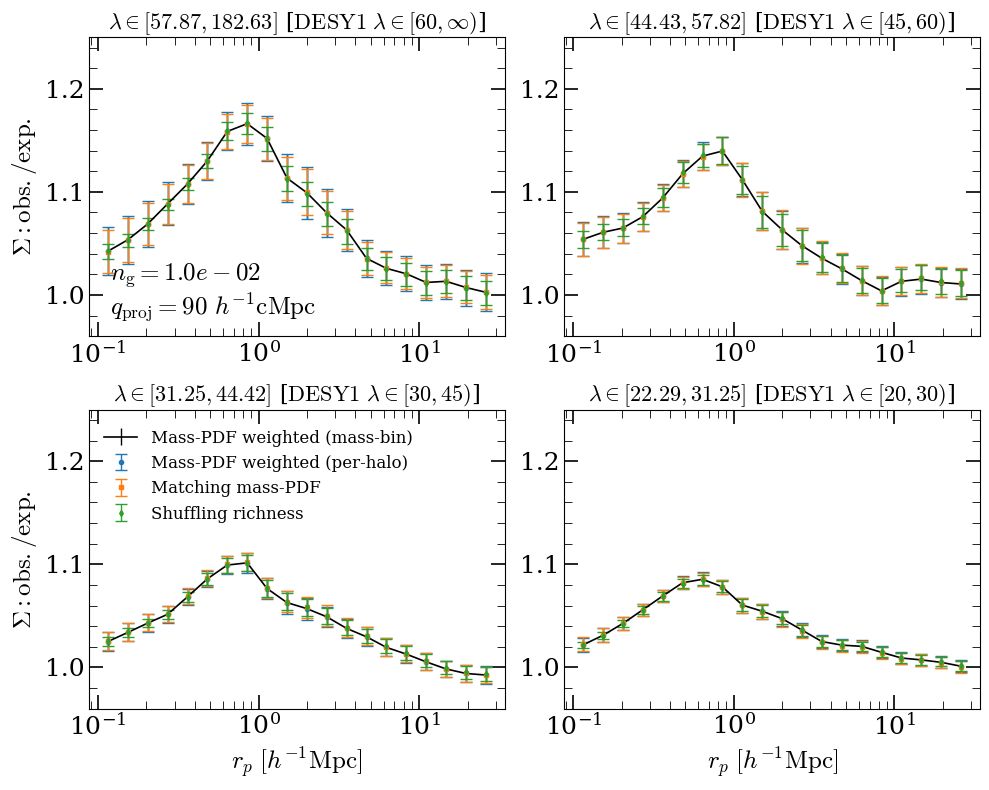

In [2]:

def main():
    # --- Cosmology (Colossus) ---
    # _ = setup_flamingo_cosmology()

    # # --- Paths ---
    # cat_base = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/HYDRO_FIDUCIAL/z0.3/"
    # data_m3_path = "/projects/lyang4/projection_effects/cluster_cosmology/Flamingo/L1000N3600/data/data_m3/"
    # halo_prop_path = (
    #     "/projects/lyang4/projection_effects/cluster_cosmology/multi_wave/halos/"
    #     "L1000N3600_HYDRO_FIDUCIAL_halos_m500c_cut_1e13_withID.hdf5"
    # )

    # Load halo_id once
    halo_id = load_halo_id(halo_prop_path)

    # --- User parameters ---
    Mcut = 1e13 ### Unit: Msun (6.81e12 Msun/h)
    gal_dens = ["1.2e-02", "1.0e-02", "8.0e-03", "6.0e-03", "4.0e-03", "2.0e-03", "1.0e-03"]
    gal_dens_num = [1.2e-2, 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3]

    cyl_depth = [30, 60, 90, 120, 180] ### comoving Mpc/h for count-in-cylinder richness
    proj_depth = [60, 90, 180, 300]    ### comoving Mpc/h for r_{\pi} lensing and cy

    Mz_cut = [20, 21, 21.5, 22]  ### z-band abs_magnitdue cut  (negligible)
    chi2_cut = [6, 8, 10, 50, 100, 150] ### chi2_cut for color (does not matter)

    richness_labels = [
        r" [$\rm DESY1~\lambda\in[60, \infty)$]",
        r" [$\rm DESY1~\lambda\in[45, 60)$]",
        r" [$\rm DESY1~\lambda\in[30, 45)$]",
        r" [$\rm DESY1~\lambda\in[20, 30)$]",
    ]

    numlam_DESY1 = np.array([0, 280, 379, 1159, 2349])  # cumulative edges

    n_rpbins = 20

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # For diagnostic: fix three indices 
    cc = 0   # chi2_cut index -> 6
    mz = 0   # Mz_cut index  -> 20 absmag
    k  = 3   # proj_depth index -> 300 cMpc/h

    for i in range(1, 2):   # gal_dens index -> 1e02
        for j in range(2, 3):  # cyl_depth index -> 90 cMpc/h
            model_dir = os.path.join(cat_base, f"model_redmagic_chi{chi2_cut[cc]}_{gal_dens[i]}_HBT")

            file_matchID  = os.path.join(
                model_dir,
                f"matched_haloID_M500c_cut{Mcut:.0e}_q{cyl_depth[j]}_Mz_cut-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )
            file_richness = os.path.join(
                model_dir,
                f"richness_q{cyl_depth[j]}_bg_NOmiscen_m500c_Mzmin-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )

            if not os.path.exists(file_richness):
                print("[**skip**] richness file missing:", file_richness)
                continue

            richness, cyl_hm, cyl_hid = load_cylinder_cluster_richness(file_richness)
            matched_id = load_cylinder_cluster_halo_matchID(file_matchID)

            halo_mass, DS_halo, Sigma_halo, rp_list, hid_lensing = load_halo_lensing_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )
            hmass_cy, cy_halo, rp_cy, hid_cy = load_halo_cy_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )

            # Sanity check ID alignment
            if not verify_ids_match({"lensing": hid_lensing, "richness": cyl_hid}):
                print("[warn] lensing IDs do not match richness IDs")
            if not verify_ids_match({"cy": hid_cy, "richness": cyl_hid}):
                print("[warn] cy IDs do not match richness IDs")

            print("Matched halo number:", len(richness))

            # Rank by cic-richness
            sort_lam = np.argsort(richness)[::-1]
            richness_sort = richness[sort_lam]
            hm_sort       = halo_mass[sort_lam]
            DS_sort       = DS_halo[sort_lam]
            Sigma_sort    = Sigma_halo[sort_lam]
            cy_sort       = cy_halo[sort_lam]

            # --- Set mass bin ---
            logM = np.log(hm_sort)
            print(80*'+')
            print('mass range:', hm_sort.min(), hm_sort.max())
            print('mass range (log/ln):', logM.min(), logM.max())
            dlogM = 0.05
            edges = np.arange(logM.min(), logM.max() + dlogM, dlogM)
            if edges[-1] <= logM.max():
                edges = np.append(edges, logM.max() + 1e-12)
            centers = 0.5 * (edges[:-1] + edges[1:])
            # ------------------------------------------------------
            for ii, ax in enumerate(axes.flat):
                i_desy1 = ii + 1
                start_lam_id = np.sum(numlam_DESY1[:i_desy1])
                end_lam_id   = np.sum(numlam_DESY1[:i_desy1 + 1])

                sel_lam = np.zeros(len(richness_sort), dtype=bool)
                sel_lam[start_lam_id:end_lam_id] = True


                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # Expected profiles from mass-PDF weighting (mass-bin) old version
                
                lnsig_w, lnsig_err, _, _ = mass_pdf_weighted_lensing_with_sampling_err(
                    mass=hm_sort,
                    delta_sigma=Sigma_sort,
                    rich_mask=sel_lam,
                    dlogM=dlogM,
                    mean_type="linear",
                    edges=edges
                )


                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # --- Use "all" halos but weight each halo's profile by the (blue histogram) observed mass PDF ---

                lnsig_w2, lnsig_err2, _, _ = mass_pdf_weighted_per_halo_lensing(
                    hm_sort, Sigma_sort, sel_lam, dlogM=dlogM, mean_type="linear", edges=edges
                )
                

                # ### Check different weights ###
                # print("max frac diff DS:", np.nanmax(np.abs(lnds_w2 - lnds_w) / np.abs(lnds_w)))

                # Wu+2022 method(ii): mass-matched expected
                # We draw 5 times the number of the richness-selected sample that exactly match the mass PDF
                # For massive halos, draw with replacement
                # Note: return the average over realizations
                Sig_mm, Sig_mm_std, _ = mass_matched_sample_expected(
                    mass=hm_sort,
                    profile=Sigma_sort,
                    sel_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    factor=5,
                    n_real=50,
                    mean_type="linear",
                    seed=476638,
                )
                
                # Wu+2022 method(i): shuffling richness 
                # Note: return the mean and std of obs/shuff ratios 

                ratio_Sig_shuff, ratio_Sig_shuff_std = shuffled_richness_selection_bias_ratio(
                    mass=hm_sort,
                    richness=richness_sort,
                    profile=Sigma_sort,
                    #lam_range=(richness_sort[sel_lam].min(), richness_sort[sel_lam].max()),
                    #sel_mask=sel_lam,
                    rank_slice=(start_lam_id, end_lam_id),
                    obs_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    n_shuffle=100,
                    mean_type="linear",
                    seed=742289,
                )

                # --- observed stacked profiles in richness bin ---
                lnDS_mean, lnDS_err, lnSig_mean, lnSig_err = calc_mean_lensing_with_std_err(
                    delta_sigma=DS_sort[sel_lam],
                    sigma=Sigma_sort[sel_lam],
                    mean_type="linear",
                )

                # --- plot comparison of three diagnosis methods ---
                # --- for \Sigma ---

                ratio_mpdf   = lnSig_mean / lnsig_w
                yerr_mpdf    = ratio_mpdf * (lnSig_err / lnSig_mean)
                yerr_mpdf_v2 = ratio_mpdf * np.sqrt((lnSig_err/lnSig_mean)**2 + (lnsig_err/lnsig_w)**2)
                ax.errorbar(rp_list, 
                            ratio_mpdf, 
                            yerr = yerr_mpdf_v2,
                            fmt='-', lw=1.2, ms=0, #fmts[i], ms=2,
                            color = 'black',
                            elinewidth=1, capsize=0, capthick=1, zorder=3,
                            label="Mass-PDF weighted (mass-bin)")

                ratio_mpdf2   = lnSig_mean / lnsig_w2
                yerr_mpdf2    = ratio_mpdf2 * (lnSig_err / lnSig_mean) # fractional error
                yerr_mpdf2_v2 = ratio_mpdf2 * np.sqrt((lnSig_err/lnSig_mean)**2 + (lnsig_err2/lnsig_w2)**2) # include all errors
                ax.errorbar(rp_list, 
                            ratio_mpdf2, 
                            yerr = yerr_mpdf2_v2,
                            fmt='o', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Mass-PDF weighted (per-halo)")
                ratio_mm   = lnSig_mean / Sig_mm
                yerr_mm    = ratio_mm * (lnSig_err/lnSig_mean)
                yerr_mm_v2 = ratio_mm * np.sqrt((lnSig_err/lnSig_mean)**2 + (Sig_mm_std/Sig_mm)**2)
                ax.errorbar(rp_list, 
                            ratio_mm, 
                            yerr = yerr_mm_v2,
                            fmt='s', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Matching mass-PDF")
                
                ax.errorbar(rp_list, 
                            ratio_Sig_shuff,
                            yerr = ratio_Sig_shuff_std,
                            fmt='d', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Shuffling richness")

                ax.set_title(
                    rf'$\lambda\in [{richness_sort[sel_lam].min():.2f}, {richness_sort[sel_lam].max():.2f}]$'
                    + richness_labels[ii],
                    fontsize=16,
                )
                if ii >= 2:
                    # ax.set_xlabel(r'$\log_{10}(M_{\rm 500c})\ [\rm M_\odot \it h^{-1}]$', fontsize=18)
                    ax.set_xlabel(r'$r_p\ [h^{-1}{\rm Mpc}]$', fontsize=18)

                if (ii%2) == 0:
                    ax.set_ylabel(r"$\Sigma: \rm obs./exp.$", fontsize=18)
        
                if ii == 2:
                    ax.legend(fontsize=12, loc=[0.02, 0.6], ncols=1,frameon=False)
                if ii == 0:
                    
                    ax.text(
                        0.05, 0.25,
                        rf"$n_{{\mathrm{{g}}}} = {gal_dens_num[i]:.1e}$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )
                    ax.text(
                        0.05, 0.15,
                        r"$q_{\rm proj}$" + rf"$ = {cyl_depth[j]}$ " + r"$h^{-1}\rm cMpc$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )

                ax.tick_params(axis="both", which="both", labelsize=18, length=6, width=0.6,
                               top=True, right=True, direction="in")
                ax.tick_params(axis="both", which="major", length=10, width=1.2,
                               top=True, right=True, direction="in")
                ax.minorticks_on()
                ax.set_ylim(0.96, 1.25)
                ax.set_xscale('log')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Matched halo number: 78551
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
mass range: 6809999882846.207 866449946956529.6
mass range (log/ln): 29.54941321888677 34.39542545879549


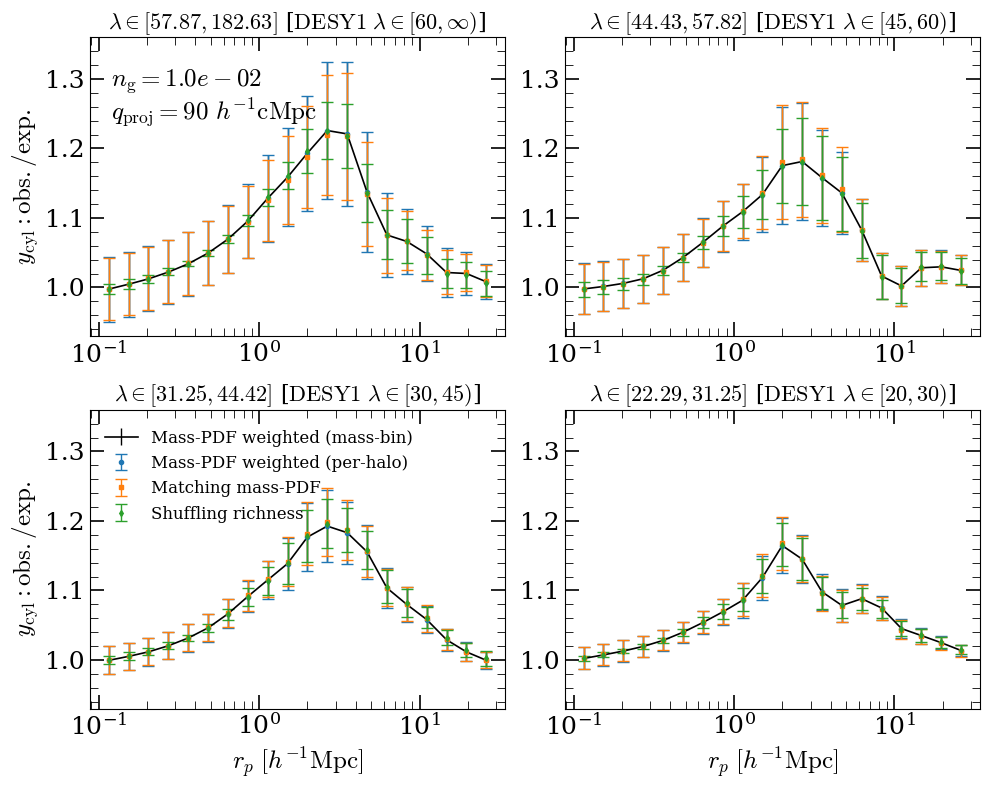

In [3]:
def main():


    # Load halo_id once
    halo_id = load_halo_id(halo_prop_path)

    # --- User parameters ---
    Mcut = 1e13 ### Unit: Msun (6.81e12 Msun/h)
    gal_dens = ["1.2e-02", "1.0e-02", "8.0e-03", "6.0e-03", "4.0e-03", "2.0e-03", "1.0e-03"]
    gal_dens_num = [1.2e-2, 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3]

    cyl_depth = [30, 60, 90, 120, 180] ### comoving Mpc/h for count-in-cylinder richness
    proj_depth = [60, 90, 180, 300]    ### comoving Mpc/h for r_{\pi} lensing and cy

    Mz_cut = [20, 21, 21.5, 22]  ### z-band abs_magnitdue cut  (negligible)
    chi2_cut = [6, 8, 10, 50, 100, 150] ### chi2_cut for color (does not matter)

    richness_labels = [
        r" [$\rm DESY1~\lambda\in[60, \infty)$]",
        r" [$\rm DESY1~\lambda\in[45, 60)$]",
        r" [$\rm DESY1~\lambda\in[30, 45)$]",
        r" [$\rm DESY1~\lambda\in[20, 30)$]",
    ]

    numlam_DESY1 = np.array([0, 280, 379, 1159, 2349])  # cumulative edges

    n_rpbins = 20

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # For diagnostic: fix three indices 
    cc = 0   # chi2_cut index -> 6
    mz = 0   # Mz_cut index  -> 20 absmag
    k  = 3   # proj_depth index -> 300 cMpc/h

    for i in range(1, 2):   # gal_dens index -> 1e02
        for j in range(2, 3):  # cyl_depth index -> 90 cMpc/h
            model_dir = os.path.join(cat_base, f"model_redmagic_chi{chi2_cut[cc]}_{gal_dens[i]}_HBT")

            file_matchID  = os.path.join(
                model_dir,
                f"matched_haloID_M500c_cut{Mcut:.0e}_q{cyl_depth[j]}_Mz_cut-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )
            file_richness = os.path.join(
                model_dir,
                f"richness_q{cyl_depth[j]}_bg_NOmiscen_m500c_Mzmin-{Mz_cut[mz]}_{gal_dens_num[i]:.1e}.fit",
            )

            if not os.path.exists(file_richness):
                print("[**skip**] richness file missing:", file_richness)
                continue

            richness, cyl_hm, cyl_hid = load_cylinder_cluster_richness(file_richness)
            matched_id = load_cylinder_cluster_halo_matchID(file_matchID)

            halo_mass, DS_halo, Sigma_halo, rp_list, hid_lensing = load_halo_lensing_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )
            hmass_cy, cy_halo, rp_cy, hid_cy = load_halo_cy_data(
                data_m3_path=data_m3_path,
                proj_depth=proj_depth[k],
                match_id=matched_id,
                halo_id=halo_id,
            )

            # Sanity check ID alignment
            if not verify_ids_match({"lensing": hid_lensing, "richness": cyl_hid}):
                print("[warn] lensing IDs do not match richness IDs")
            if not verify_ids_match({"cy": hid_cy, "richness": cyl_hid}):
                print("[warn] cy IDs do not match richness IDs")

            print("Matched halo number:", len(richness))

            # Rank by cic-richness
            sort_lam = np.argsort(richness)[::-1]
            richness_sort = richness[sort_lam]
            hm_sort       = halo_mass[sort_lam]
            DS_sort       = DS_halo[sort_lam]
            Sigma_sort    = Sigma_halo[sort_lam]
            cy_sort       = cy_halo[sort_lam]

            # --- Set mass bin ---
            logM = np.log(hm_sort)
            print(80*'+')
            print('mass range:', hm_sort.min(), hm_sort.max())
            print('mass range (log/ln):', logM.min(), logM.max())
            dlogM = 0.05
            edges = np.arange(logM.min(), logM.max() + dlogM, dlogM)
            if edges[-1] <= logM.max():
                edges = np.append(edges, logM.max() + 1e-12)
            centers = 0.5 * (edges[:-1] + edges[1:])
            # ------------------------------------------------------
            for ii, ax in enumerate(axes.flat):
                i_desy1 = ii + 1
                start_lam_id = np.sum(numlam_DESY1[:i_desy1])
                end_lam_id   = np.sum(numlam_DESY1[:i_desy1 + 1])

                sel_lam = np.zeros(len(richness_sort), dtype=bool)
                sel_lam[start_lam_id:end_lam_id] = True

                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # Expected profiles from mass-PDF weighting (mass-bin) old version
                cy_w, cy_err, _, _ = mass_pdf_weighted_lensing_with_sampling_err(
                    mass=hm_sort,
                    delta_sigma=cy_sort,
                    rich_mask=sel_lam,
                    dlogM=dlogM,
                    mean_type="linear",
                    edges=edges
                )

                # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # Wu+2022 method(iii) 
                # --- Use "all" halos but weight each halo's profile by the (blue histogram) observed mass PDF ---
                
                cy_w2, cy_err2, _, _ = mass_pdf_weighted_per_halo_lensing(
                    hm_sort, cy_sort, sel_lam, dlogM=dlogM, mean_type="linear", edges=edges
                )
                # ### Check different weights ###
                # print("max frac diff DS:", np.nanmax(np.abs(lnds_w2 - lnds_w) / np.abs(lnds_w)))

                # Wu+2022 method(ii): mass-matched expected
                # We draw 5 times the number of the richness-selected sample that exactly match the mass PDF
                # For massive halos, draw with replacement
                # Note: return the average over realizations

                cy_mm, cy_mm_std, _ = mass_matched_sample_expected(
                    mass=hm_sort,
                    profile=cy_sort,
                    sel_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    factor=5,
                    n_real=50,
                    mean_type="linear",
                    seed=476638,
                )
                
                # Wu+2022 method(i): shuffling richness 
                # Note: return the mean and std of obs/shuff ratios 
                ratio_cy_shuff, ratio_cy_shuff_std = shuffled_richness_selection_bias_ratio(
                    mass=hm_sort,
                    richness=richness_sort,
                    profile=cy_sort,
                    #lam_range=(richness_sort[sel_lam].min(), richness_sort[sel_lam].max()),
                    #sel_mask=sel_lam,
                    rank_slice=(start_lam_id, end_lam_id),
                    obs_mask=sel_lam,
                    dlogM=0.05,
                    edges=edges,
                    n_shuffle=100,
                    mean_type="linear",
                    seed=742289,
                )
                
                # --- observed stacked profiles in richness bin ---
                cy_mean, cy_mean_err = calc_mean_cy_with_std_err(
                    profile=cy_sort[sel_lam],
                    mean_type="linear",
                )

                
                # --- plot comparison of three diagnosis methods ---
                # --- for Compton-y profile ---

                ratio_mpdf   = cy_mean / cy_w
                yerr_mpdf    = ratio_mpdf * (cy_mean_err / cy_mean)
                yerr_mpdf_v2 = ratio_mpdf * np.sqrt((cy_mean_err/cy_mean)**2 + (cy_err/cy_w)**2)
                ax.errorbar(rp_list, 
                            ratio_mpdf, 
                            yerr = yerr_mpdf_v2,
                            fmt='-', lw=1.2, ms=0, #fmts[i], ms=2,
                            color = 'black',
                            elinewidth=1, capsize=0, capthick=1, zorder=3,
                            label="Mass-PDF weighted (mass-bin)")

                ratio_mpdf2   = cy_mean / cy_w2
                yerr_mpdf2    = ratio_mpdf2 * (cy_mean_err / cy_mean) # fractional error
                yerr_mpdf2_v2 = ratio_mpdf2 * np.sqrt((cy_mean_err/cy_mean)**2 + (cy_err2/cy_w2)**2) # include all errors
                ax.errorbar(rp_list, 
                            ratio_mpdf2, 
                            yerr = yerr_mpdf2_v2,
                            fmt='o', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Mass-PDF weighted (per-halo)")
                ratio_mm   = cy_mean / cy_mm
                yerr_mm    = ratio_mm * (cy_mean_err/cy_mean)
                yerr_mm_v2 = ratio_mm * np.sqrt((cy_mean_err/cy_mean)**2 + (cy_mm_std/cy_mm)**2)
                ax.errorbar(rp_list, 
                            ratio_mm, 
                            yerr = yerr_mm_v2,
                            fmt='s', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Matching mass-PDF")
                
                ax.errorbar(rp_list, 
                            ratio_cy_shuff,
                            yerr = ratio_cy_shuff_std,
                            fmt='d', ms=3, #fmts[i], ms=2,
                            #color = colors[j],
                            elinewidth=1, capsize=4, capthick=1, zorder=3,
                            label="Shuffling richness")

                ax.set_title(
                    rf'$\lambda\in [{richness_sort[sel_lam].min():.2f}, {richness_sort[sel_lam].max():.2f}]$'
                    + richness_labels[ii],
                    fontsize=16,
                )
                if ii >= 2:
                    # ax.set_xlabel(r'$\log_{10}(M_{\rm 500c})\ [\rm M_\odot \it h^{-1}]$', fontsize=18)
                    ax.set_xlabel(r'$r_p\ [h^{-1}{\rm Mpc}]$', fontsize=18)

                if (ii%2) == 0:
                    ax.set_ylabel(r"$y_{\rm cyl}: \rm obs./exp.$", fontsize=18)
        
                if ii == 2:
                    ax.legend(fontsize=12, loc=[0.02, 0.6], ncols=1,frameon=False)
                if ii == 0:
                    
                    ax.text(
                        0.05, 0.9,
                        rf"$n_{{\mathrm{{g}}}} = {gal_dens_num[i]:.1e}$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )
                    ax.text(
                        0.05, 0.8,
                        r"$q_{\rm proj}$" + rf"$ = {cyl_depth[j]}$ " + r"$h^{-1}\rm cMpc$",
                        transform=ax.transAxes, fontsize=18, ha="left", va="top",
                    )

                ax.tick_params(axis="both", which="both", labelsize=18, length=6, width=0.6,
                               top=True, right=True, direction="in")
                ax.tick_params(axis="both", which="major", length=10, width=1.2,
                               top=True, right=True, direction="in")
                ax.minorticks_on()
                ax.set_ylim(0.93, 1.36)
                ax.set_xscale('log')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
